In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq ` upgrades to the latest version of 
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# U = upgrade, q = quiet
if iskaggle:
    !pip install -Uqq fastai duckduckgo_search 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 14.0.2 which is incompatible.


In [3]:
from fastai.vision.widgets import *

In [4]:
from duckduckgo_search import AsyncDDGS

from fastcore.all import *

def search_images(term, max_images=200):
    print(f"Searching for '{term}'")
    results = AsyncDDGS().images(keywords=term, region='wt-wt', safesearch='off', max_results=max_images)
    return L(results).itemgot('image')

## Get data

In [5]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
results = search_images('grizzly bear')
print(len(results))
results[0]

Searching for 'grizzly bear'
178


'http://2.bp.blogspot.com/-NjMTuklENdE/UHzVv_8dIxI/AAAAAAAAA-U/tNBsQDn8kFI/s1600/Grizzly+Bear+Pic.jpg'

### Download url to view the image

In [6]:
from fastdownload import download_url

dest = 'images/grizzly.jpg'
download_url(results[0], dest, show_progress=False)

Path('images/grizzly.jpg')

### View the image

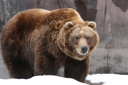

In [7]:
# view the image
from fastai.vision.all import *

im = Image.open(dest)
im.to_thumb(128,128)

In [8]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [9]:
for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=(search_images(f'{o} bear')))

Searching for 'grizzly bear'
Searching for 'black bear'
Searching for 'teddy bear'


#### Check if files exist in folders

In [10]:
fns = get_image_files(path)
fns

(#512) [Path('bears/grizzly/732fd9b5-5338-48d2-9b25-d47225fe7d76.jpg'),Path('bears/grizzly/dd8f1b7b-cbf0-4e8d-bb11-630aa08d3fed.jpg'),Path('bears/grizzly/af52d22e-6ef6-42e0-97ed-646bdf27cb86.jpg'),Path('bears/grizzly/12946d15-b49c-4c3c-ac04-a3ab98fff4ca.jpg'),Path('bears/grizzly/36b8146d-c4da-443d-b0b8-6bc9e6bee9df.jpg'),Path('bears/grizzly/0ad9d19d-277a-4017-bbaf-527f5b3b54b3.jpg'),Path('bears/grizzly/c25bf7d8-c36a-4d75-a4f9-1feed827425e.jpg'),Path('bears/grizzly/05e0eb18-63fa-4a66-8b32-fdd7dd0e9c0b.jpg'),Path('bears/grizzly/3e03c969-6701-43bb-8aa0-63583d3df33c.jpg'),Path('bears/grizzly/3dadc591-01a6-489f-acb3-fec47893d0a8.jpg')...]

### Remove failed images

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

22

## Build model

In [12]:
bears = DataBlock(
    # define input, output
    blocks = (ImageBlock, CategoryBlock),
    
    # get data
    get_items = get_image_files,
    
    # train, test split
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    
    # return parent label of a path ('bears')
    get_y=parent_label,
    
    # resize images
    item_tfms=Resize(128)
)

In [13]:
# dataloaders give you 64 (by default) items at a time, all stacked up into a single tensor
dls = bears.dataloaders(path)

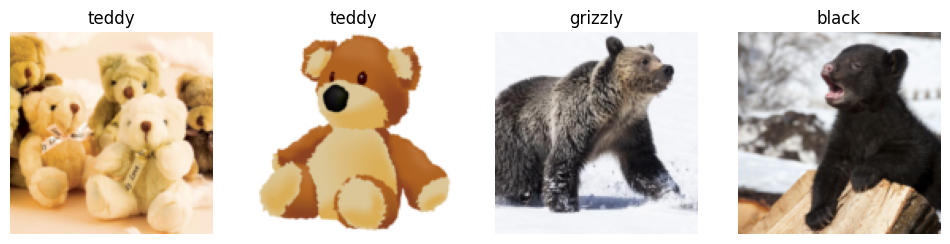

In [14]:
dls.valid.show_batch(max_n=4, nrows=1)

### View images with `squish` mode

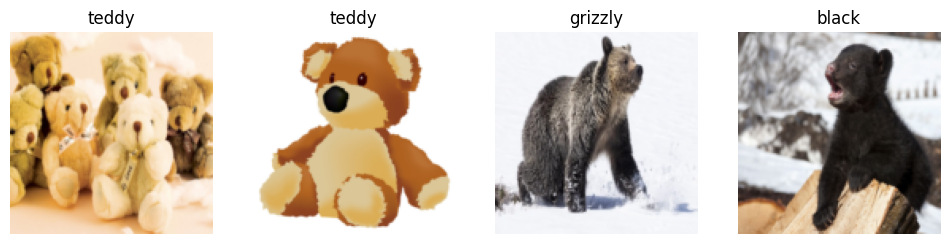

In [15]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

### View images with `padding` mode

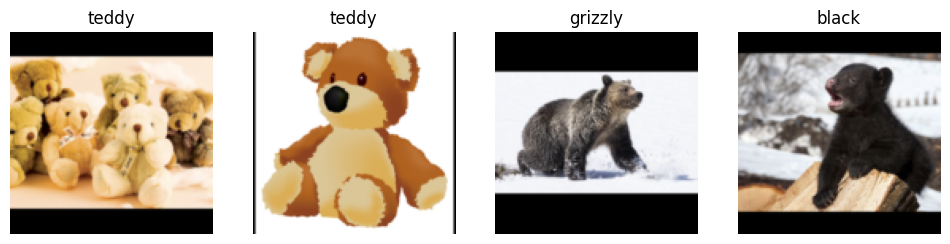

In [16]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

* Squish and add paddings can lead to a model that learns that things look different to how they actually are, which we would expect to result in lower accuracy. 
* It's better to train model with randomly selected features of the image, which can help the model to focus and recognize different features in our images.

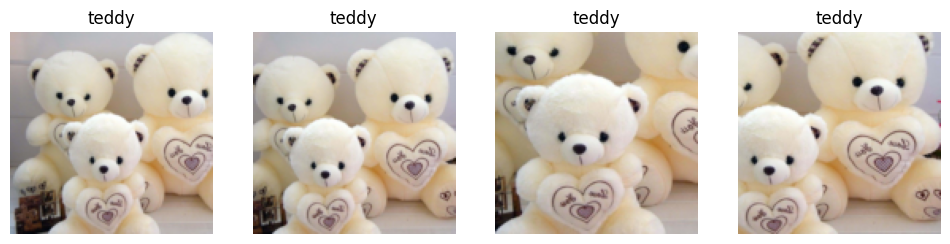

In [17]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

* `Data augmentation` refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data.
* Examples of common data augmentation techniques: rotation, flipping, perspective warping, brightness changes and contrast changes.

## Train model and using it to clean data

In [18]:
bears = bears.new(
    item_tfms = RandomResizedCrop(224, min_scale=0.5),
    batch_tfms = aug_transforms()
)

dls = bears.dataloaders(path)

#### Create learner and fine-tune

In [19]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,1.087275,0.358277,0.142857,00:12


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.146105,0.161970,0.030612,00:12
1,0.107589,0.169009,0.020408,00:12
2,0.091550,0.177947,0.030612,00:12
3,0.073944,0.183226,0.020408,00:12


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#### Plot confusion matrix

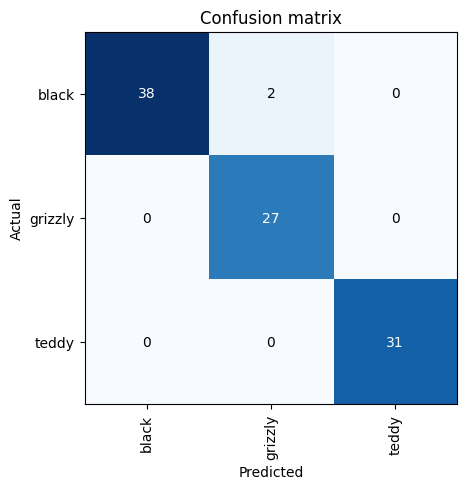

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### Plot top losses

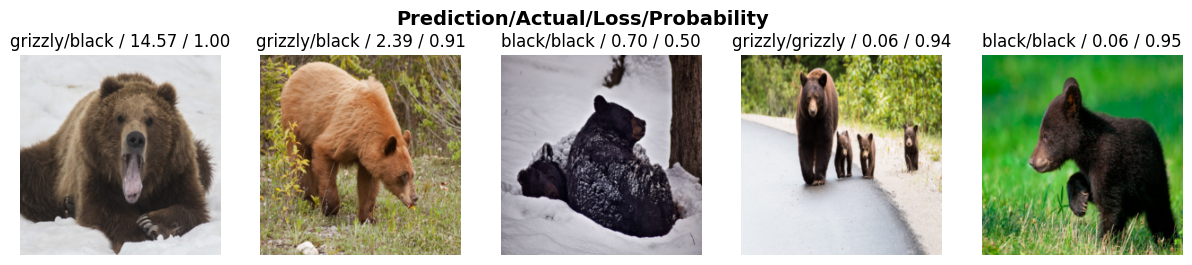

In [21]:
interp.plot_top_losses(5, nrows=1)

### Use `ImageClassifierCleaner` to clean data

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# get all from deleted list and delete them
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()   
    
# # get all from moved list and move them
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Export model

#### When you call `export`, fastai will save a file called "export.pkl":

In [24]:
learn.export()

#### Check that the file exists, by using the ls method that fastai adds to Python's Path class:

In [25]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

### Create our inference learner from the exported file

In [26]:
learn_inf = load_learner(path/'export.pkl')

#### Get predictions for one image at a time

In [27]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([4.5798e-06, 9.9999e-01, 1.4002e-06]))

* 'grizzly': predicted label
* tensor(1): index of predicted label
* tensor([4.5798e-06, 9.9999e-01, 1.4002e-06])): probabilities corresponding to 'grizzly', 'black', 'teddy' labels

In [29]:
#|export
categories = ('grizzly', 'black', 'teddy')

def classify_image(img):
    pred, idx, probs = learn_inf.predict(img)
    return dict(zip(categories, map(float, probs)))

In [30]:
classify_image('images/grizzly.jpg')

{'grizzly': 4.5798274186381605e-06,
 'black': 0.9999940395355225,
 'teddy': 1.4002134776092134e-06}